In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sn
from PIL import Image

print(tf.__version__)

2.7.0


In [2]:
#Check if GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
CLASSES=["fabric", "foliage", "glass", "leather", "metal", "paper", "plastic", "stone", "water", "wood"]

##  Dataset Preparation

Split the dataset ....

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

# prefetch the dataset
#https://www.tensorflow.org/tutorials/load_data/images
def configure_for_performance(ds,batch_size):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


def getFMDdataset(image_dir,batch_size=8,img_size=(224,224)):
    CLASSES=["fabric", "foliage", "glass", "leather", "metal", "paper", "plastic", "stone", "water", "wood"]


    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(image_dir,
                                                                class_names=CLASSES,
                                                                shuffle=True,
                                                                batch_size=batch_size,
                                                                image_size=img_size,
                                                                seed=0,
                                                                validation_split=0.2,
                                                                subset="training",
                                                                interpolation='lanczos3',
                                                                #crop_to_aspect_ratio=True,
                                                               )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory( image_dir,
                                                                class_names=CLASSES,
                                                                shuffle=True,
                                                                batch_size=batch_size,
                                                                image_size=img_size,
                                                                seed=0,
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                interpolation='lanczos3',
                                            #only avail in tf 2.6 #crop_to_aspect_ratio=True,
                                                               )
    train_dataset = train_dataset
    val_dataset=val_dataset

    return train_dataset,val_dataset

In [129]:
data_dir = r"C:\Users\tanch\Documents\NTU\NTU Year 3\Sem 1\CZ4042 Deep Learning and Neural Networks\Assignment 2\code\data\FMD (1)\image"
train_dataset,val_dataset= getFMDdataset(data_dir,8,(100,100))

Found 1000 files belonging to 10 classes.
Using 800 files for training.
Found 1000 files belonging to 10 classes.
Using 200 files for validation.


In [6]:
IMAGE_SIZE = [100, 100]
AUG_BATCH = 8
BATCH_SIZE = 8
NUM_CLASSES = len(CLASSES)

In [79]:
def onehot(image,label):

    return image,tf.one_hot(label,NUM_CLASSES)

def cutmix(image, label,augment_fraction): #, PROBABILITY = 1.0
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    
    
    imgs = []; labs = []
    
        
    for j in range(AUG_BATCH):
        
        augment_the_image = np.random.choice([0,1],p = [1-augment_fraction,augment_fraction])
        
        if augment_the_image:
            # CHOOSE RANDOM IMAGE TO CUTMIX WITH
            k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
            # CHOOSE RANDOM LOCATION
            x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
            y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
            b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
            WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32)
            ya = tf.math.maximum(0,y-WIDTH//2)
            yb = tf.math.minimum(DIM,y+WIDTH//2)
            xa = tf.math.maximum(0,x-WIDTH//2)
            xb = tf.math.minimum(DIM,x+WIDTH//2)
            # MAKE CUTMIX IMAGE
            one = image[j,ya:yb,0:xa,:]
            two = image[k,ya:yb,xa:xb,:]
            three = image[j,ya:yb,xb:DIM,:]
            middle = tf.concat([one,two,three],axis=1)
            img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
            imgs.append(img)
            # MAKE CUTMIX LABEL
            a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
            if len(label.shape)==1:
                lab1 = tf.one_hot(label[j],NUM_CLASSES)
                lab2 = tf.one_hot(label[k],NUM_CLASSES)
            else:
                lab1 = label[j,]
                lab2 = label[k,]
            labs.append((1-a)*lab1 + a*lab2)
            
        else:
            imgs.append(image[j])
            labs.append(tf.one_hot(label[j],NUM_CLASSES))
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,NUM_CLASSES))
    return image2,label2

In [ ]:
# batch, labels = list(train_dataset.take(1).as_numpy_iterator())[0]
# cutmix_batch, cutmix_labels  = cutmix(batch, labels)

In [ ]:
# train_dataset = train_dataset.map( lambda x, y: onehot(x,y), num_parallel_calls=AUTOTUNE)
# val_dataset = val_dataset.map( lambda x, y: onehot(x,y), num_parallel_calls=AUTOTUNE)

In [130]:
aug_train_dataset=train_dataset.map(lambda x, y: cutmix(x,y, augment_fraction = 0.3),num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map( lambda x, y: onehot(x,y), num_parallel_calls=AUTOTUNE)

In [134]:
# batch, labels = list(aug_train_dataset.take(35).as_numpy_iterator())[0]
# labels

array([[0.    , 0.    , 1.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ],
       [0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ],
       [1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ],
       [1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    ,
        0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ],
       [0.    , 0.    , 0.1369, 0.    , 0.8631, 0.    , 0.    , 0.    ,
        0.    , 0.    ],
       [0.    , 0.    , 1.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    ]], dtype=float32)

In [ ]:
# # import imgaug.augmenters as iaa
# import RandomAugMix 


# RAM = RandomAugMix.RandomAugMix(severity=2, width=3, alpha=1., p=1.)


# def augmix(images):
#     images = tf.cast(images, tf.uint8)
#     return np.array([RAM.apply((img)) for img in images.numpy()])        

    
# aug_train_dataset=train_dataset.map(
#             lambda x, y: (tf.py_function(augmix, [x], [tf.float32])[0], y),
#             num_parallel_calls=AUTOTUNE,
#         )


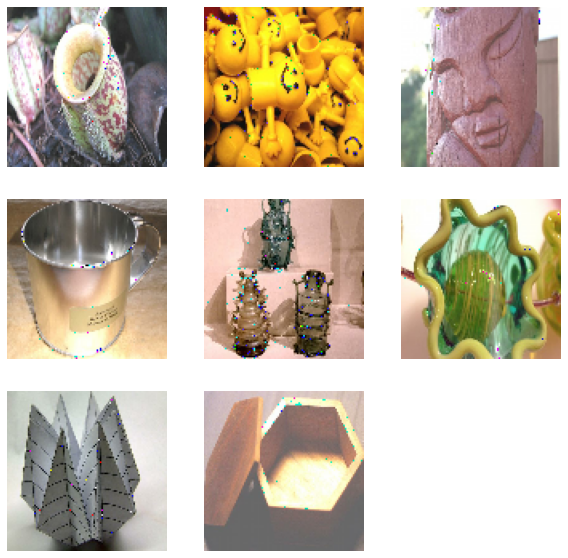

In [135]:
#visualize the dataset to ensure correctness

# original 
class_names = CLASSES
batch_size= 8
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(batch_size):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
        plt.axis("off")

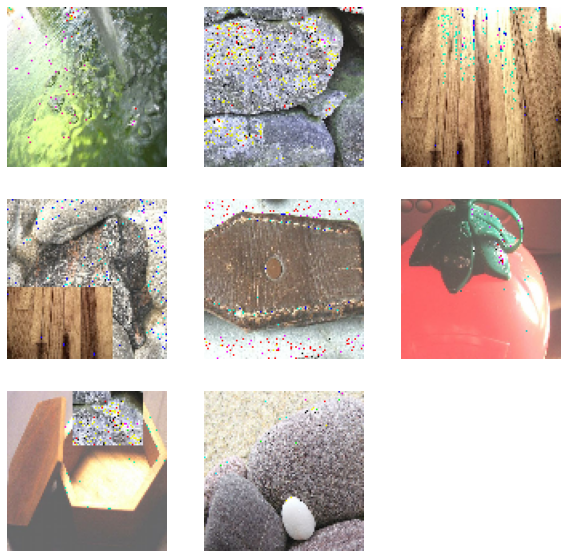

In [136]:
#visualize augmented
class_names = CLASSES
batch_size= 8
plt.figure(figsize=(10, 10))
for images, labels in aug_train_dataset.take(1):
    for i in range(batch_size):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
#         plt.title(class_names[labels[i]])
        plt.axis("off")

In [137]:
# train_dataset.concatenate(aug_train_dataset).prefetch(AUTOTUNE).shuffle(buffer_size=2000, seed = 0)
# train_dataset=train_dataset.prefetch(AUTOTUNE)
aug_train_dataset=aug_train_dataset.prefetch(AUTOTUNE)
val_dataset=val_dataset.prefetch(AUTOTUNE)

## Model


In [ ]:
#  data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),

# #      tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
#      tf.keras.layers.experimental.preprocessing.RandomZoom(.3),
#  ])


In [138]:
weights_path = r"C:\Users\tanch\Documents\GitHub\Material-Recognition\model\noisy.student.notop-b0.h5"
def efficientnet(lr):
    base_model=tf.keras.applications.EfficientNetB0(
        include_top=False,   weights=weights_path, drop_connect_rate=0.4)
    base_model.trainable=False
    base_model.training=False

    base_model._name ='base_model'
    model = tf.keras.Sequential([
        tf.keras.layers.Input((100, 100, 3)),
#         data_augmentation,
#         tf.keras.layers.Lambda(lambda x: (tf.py_function(augmix, [x], [tf.float32])[0])),
        tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, name='preprocessing', input_shape=(100, 100, 3)),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(10,activation="softmax")    
    ])
    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.losses.CategoricalCrossentropy(5, name="top-5-accuracy")])

    return model

tf.keras.backend.clear_session()
model=efficientnet(0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Lambda)      (None, 100, 100, 3)       0         
                                                                 
 base_model (Functional)     (None, None, None, 1280)  4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                1

In [139]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
EARLY_STOP_PATIENCE=10
early_stopper = EarlyStopping(monitor = 'val_accuracy', patience = EARLY_STOP_PATIENCE)
model_cp = ModelCheckpoint(filepath = './weights/efficient_augmix_best.hdf5', monitor = 'val_accuracy', save_best_only = True, mode = 'auto')

In [140]:
EPOCHS=20

history = model.fit(
        aug_train_dataset,
        epochs = EPOCHS,
        validation_data=val_dataset,
        callbacks=[model_cp, early_stopper],
        use_multiprocessing=True,
        workers=4
)

Epoch 1/20


C:\Users\tanch\anaconda3\envs\base0\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 99/100 [============================>.] - ETA: 0s - loss: 3.6910 - accuracy: 0.1907 - top-5-accuracy: 3.6910

C:\Users\tanch\anaconda3\envs\base0\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 11s 48ms/step - loss: 3.6880 - accuracy: 0.1887 - top-5-accuracy: 3.6880 - val_loss: 1.6394 - val_accuracy: 0.4750 - val_top-5-accuracy: 1.6394
Epoch 2/20
100/100 [==============================] - 4s 37ms/step - loss: 2.5708 - accuracy: 0.3587 - top-5-accuracy: 2.5708 - val_loss: 1.3577 - val_accuracy: 0.5750 - val_top-5-accuracy: 1.3577
Epoch 3/20
100/100 [==============================] - 4s 37ms/step - loss: 2.4747 - accuracy: 0.3787 - top-5-accuracy: 2.4747 - val_loss: 1.1890 - val_accuracy: 0.6200 - val_top-5-accuracy: 1.1890
Epoch 4/20
100/100 [==============================] - 4s 40ms/step - loss: 2.2095 - accuracy: 0.4387 - top-5-accuracy: 2.2095 - val_loss: 1.2069 - val_accuracy: 0.6350 - val_top-5-accuracy: 1.2069
Epoch 5/20
100/100 [==============================] - 4s 35ms/step - loss: 2.0950 - accuracy: 0.4613 - top-5-accuracy: 2.0950 - val_loss: 1.1671 - val_accuracy: 0.6250 - val_top-5-accuracy: 1.1671
Epoch 6/20
100/100 [=====

## Visualize result

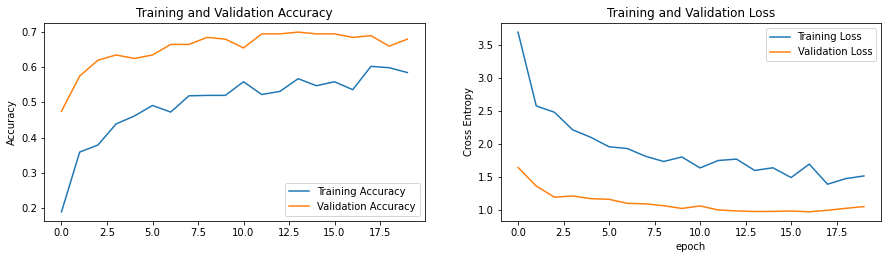

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

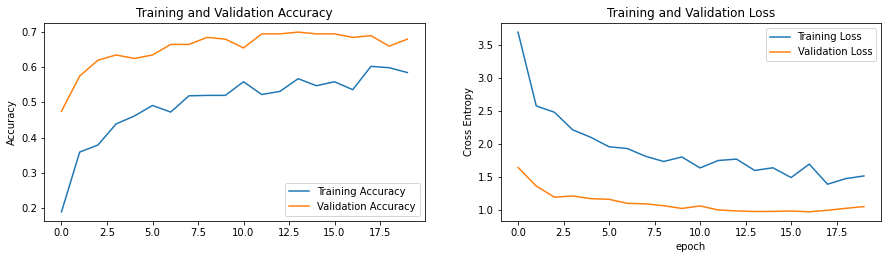

In [142]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:

def print_evaluation_result(model,val_dataset,classes):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import classification_report

    predictions_one_hot = np.array([])
    labels_one_hot =  np.array([])
    predictions = np.array([])
    labels =  np.array([])
    for x, y in val_dataset:
        categorical_labels = np.identity(10)[y.numpy()]
        prediction= model.predict(x)

        predictions_one_hot = np.concatenate([predictions_one_hot,prediction],axis=None)
        predictions = np.concatenate([predictions, np.argmax(prediction, axis=-1)],axis=None)

        labels_one_hot = np.concatenate([labels_one_hot, categorical_labels],axis=None)
        labels = np.concatenate([labels, y],axis=None)
            
    print(f'ROC_AUC score : {round(roc_auc_score(labels_one_hot, predictions_one_hot, average="weighted", multi_class="ovr"),2)} \n')
    print(classification_report(labels, predictions, target_names=classes))
    confusion_matrix= tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

    df_cm = pd.DataFrame(confusion_matrix, index = classes,
                      columns = classes)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
saved_model=tf.keras.models.load_model("weights/efficient_augmix_best.hdf5")
print_evaluation_result(saved_model,val_dataset,CLASSES)

## Fine Tuning 

In [ ]:
model.layers[2].summary()

In [ ]:

def unfreeze_model(model,lr,freeze_layers,print_base_layer=False):
    base_model_index=0
    for index,layer in enumerate(model.layers):
        if layer._name=="base_model":
            base_model_index=index
    if print_base_layer:
        print(model.layers[base_model_index].summary())
    model.layers[base_model_index].trainable=True

    #unfreeze the conv 3rd block
    fine_tune_at = len(model.layers[base_model_index].layers)-freeze_layers

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[base_model_index].layers[:fine_tune_at]:
        layer.trainable =  False
        
    # just in case,explicitly freeze all the batch normalization layer
    for layer in model.layers[base_model_index].layers[fine_tune_at:]:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
              layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy',  tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

    model.summary()


unfreeze_model(model,1e-4,16,False)


In [ ]:
fine_tune_epochs = 100
initial_epochs=history.epoch[-1]
total_epochs = initial_epochs  + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=initial_epochs,
                         validation_data=val_dataset,
                        callbacks=[model_cp, early_stopper],
                        use_multiprocessing=True,
                        workers=4)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
saved_model=tf.keras.models.load_model("weights/efficient_augmix_best.hdf5")
print_evaluation_result(saved_model,val_dataset,CLASSES)